# Getting Started

This notebook is for data preparation, it consists of two main components 
- Synthetic Data Generation
- Real handwritten data augmentation


Before starting, make sure you have downloaded the Mashtots Dataset and it sits at the same directory as the main project.

In total, the running time can take long, because thousands of files are being created, processed and move multiple times. If you wish to see the intermediate steps, you can run only the blocks left here that work for a few examples


**IMPORTANT** All the resulting files are provided (cropped_words, synthetic_data_inverted, and their corresponding labels) and they have to be stored in ./SimpleHTR/data (which was originally designed to live there and was left unchanged for the ease of use). Everything, that was made here, are placed there precisely.

In [ ]:
import os
import random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import random
import re
import pandas as pd

In [6]:
os.chdir("../..")  # left the project folder
os.getcwd()

'c:\\Users\\anial\\Downloads'

In [3]:
dataset_path = "./mashtots-dataset/Train/Train"
output_path = "./mashtots-dataset/labels.txt"

# Char mapping 

In [4]:
char_mapping = {
    0: "Ա",
    1: "Բ",
    2: "Գ",
    3: "Դ",
    4: "Ե",
    5: "Զ",
    6: "Է",
    7: "Ը",
    8: "Թ",
    9: "Ժ",
    10: "Ի",
    11: "Լ",
    12: "Խ",
    13: "Ծ",
    14: "Կ",
    15: "Հ",
    16: "Ձ",
    17: "Ղ",
    18: "Ճ",
    19: "Մ",
    20: "Յ",
    21: "Ն",
    22: "Շ",
    23: "Ո",
    24: "ՈՒ",
    25: "Չ",
    26: "Պ",
    27: "Ջ",
    28: "Ռ",
    29: "Ս",
    30: "Վ",
    31: "Տ",
    32: "Ր",
    33: "Ց",
    34: "Փ",
    35: "Ք",
    36: "Եվ",
    37: "Օ",
    38: "Ֆ",
    39: "ա",
    40: "բ",
    41: "գ",
    42: "դ",
    43: "ե",
    44: "զ",
    45: "է",
    46: "ը",
    47: "թ",
    48: "ժ",
    49: "ի",
    50: "լ",
    51: "խ",
    52: "ծ",
    53: "կ",
    54: "հ",
    55: "ձ",
    56: "ղ",
    57: "ճ",
    58: "մ",
    59: "յ",
    60: "ն",
    61: "շ",
    62: "ո",
    63: "ու",
    64: "չ",
    65: "պ",
    66: "ջ",
    67: "ռ",
    68: "ս",
    69: "վ",
    70: "տ",
    71: "ր",
    72: "ց",
    73: "փ",
    74: "ք",
    75: "և",
    76: "օ",
    77: "ֆ",
}  # notice the switch in 63 !! interestingly, in the dataset this order is being followed

# Generating the labels for the dataset

generating the refined labels so that it is apparent which image is for what letter

In [5]:
with open(output_path, "w", encoding="utf-8") as label_file:
    for subfolder in sorted(os.listdir(dataset_path)):
        subfolder_path = os.path.join(dataset_path, subfolder)

        if not os.path.isdir(subfolder_path) or int(subfolder) not in char_mapping:
            continue
        character = char_mapping[int(subfolder)]
        for img_file in sorted(os.listdir(subfolder_path)):
            img_path = os.path.join(subfolder_path, img_file)

            if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                label_file.write(f"{img_path} {character}\n")

print(f"Labels file generated at: {output_path}")

Labels file generated at: ./mashtots-dataset/labels.txt


In [6]:
output_path = "synthetic_words_refined"
os.makedirs(output_path, exist_ok=True)

# Creating Synthetic words

## scraping wiki file

in here, a from the Armenian wikipedia word scrapes, solely Armenian words are further filtered, and their subset is going to be used to generate word images

In [7]:
text_file = r"capstone-htr/data_preparation/hye_wikipedia_2021_1M-words.txt"
tsv_file = os.path.join(output_path, "image_labels.tsv")
os.makedirs(output_path, exist_ok=True)

ARMENIAN_LETTERS = (
    "ԱԲԳԴԵԶԷԸԹԺԻԼԽԾԿՀՁՂՃՄՅՆՇՈՉՊՋՌՍՎՏՐՑՒՓՔՕՖ"
    + "աբգդեզէըթժիլխծկհձղճմյունշոչպջռսվտրցւփքօֆև"
)

# normalizing "ւ"/"Ւ" to "ու"/"ՈՒ" in words


def normalize_word(word):
    word = re.sub(r"(?<![Ոո])Ւ", "ՈՒ", word)
    word = re.sub(r"(?<![ոՈ])ւ", "ու", word)
    return word


cleaned_words = []
with open(text_file, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) < 2:
            continue

        word = normalize_word(parts[1])

        if not all(
            char in ARMENIAN_LETTERS
            for char in word.replace("ու", "").replace("ՈՒ", "")
        ):
            continue

        cleaned_words.append(word)

print(f"Found {len(cleaned_words)} valid Armenian words")

Found 628626 valid Armenian words


Here we define the 4 main categories for Armenian Letters
- Tall ascenders : the ones that lie above the writing line and extend high
- Short descenders : those who are mainly extending below the writing line and have a short proportion above it
- Long both sides: the ones thatextend both below and above the line in an equal amount
- Short letters: the ones that lie above the line and are extending very little

In [8]:
tall_ascenders = {
    "Ա",
    "Ե",
    "Զ",
    "Ժ",
    "Ծ",
    "Հ",
    "Ձ",
    "Ճ",
    "Մ",
    "Ն",
    "Շ",
    "Ո",
    "Չ",
    "Ռ",
    "Ս",
    "Տ",
    "ՈՒ",
    "Օ",
    "և",
    "ն",
    "ե",
    "ժ",
    "ծ",
    "հ",
    "ճ",
    "մ",
}
short_descenders = {
    "բ",
    "գ",
    "դ",
    "զ",
    "ը",
    "թ",
    "լ",
    "ձ",
    "ղ",
    "յ",
    "շ",
    "չ",
    "պ",
    "ջ",
    "տ",
    "ր",
    "ց",
    "Լ",
    "Ը",
}
long_both_sides = {
    "ի",
    "խ",
    "է",
    "կ",
    "փ",
    "ֆ",
    "ք",
    "Ք",
    "Է",
    "Ֆ",
    "Փ",
    "Բ",
    "Գ",
    "Դ",
    "Թ",
    "Ի",
    "Խ",
    "Կ",
    "Ղ",
    "Պ",
    "Ջ",
    "Յ",
    "վ",
    "Վ",
    "Ր",
    "Ց",
    "Եվ",
}
short_letters = {"ա", "ո", "ու", "օ", "ռ", "ս"}

BASELINE_HEIGHT_RATIO = 0.65

In [9]:
def detect_skew_angle_pca(gray):
    """
    Detects the skew angle of a grayscale letter image using PCA on non-zero pixels.

    Parameters:
        gray (numpy.ndarray): A grayscale image of a letter.

    Returns:
        float: Estimated skew angle in degrees. Returns 0 if insufficient foreground pixels.
    """

    _, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    coords = np.column_stack(np.where(bin_img > 0))
    if len(coords) < 5:
        return 0
    angle = cv2.fitEllipse(coords)[-1]
    if angle > 90:
        angle -= 180
    return angle


def deskew_image(image, angle):
    """
    Rotates the input image by the specified angle to correct skew.

    Parameters:
        image (numpy.ndarray): The input image (grayscale or color).
        angle (float): The rotation angle in degrees.

    Returns:
        numpy.ndarray: The deskewed (rotated) image.
    """

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(
        image, rot_mat, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    return rotated


def deskew_letter_image(image):
    """
    Automatically estimates and corrects skew in a letter image.

    Parameters:
        image (numpy.ndarray): The input image (grayscale or color) containing a single letter.

    Returns:
        numpy.ndarray: The corrected, deskewed image.
    """

    angle = detect_skew_angle_pca(image)
    if abs(angle) > 20:
        angle = 0
    corrected = deskew_image(image, angle)
    return corrected

In [ ]:
def extract_letter_pixels(image, char):
    """
    Extracts and resizes the letter region from a given character image.

    Parameters:
        image (numpy.ndarray): The input image of a single letter.
        char (str): The character corresponding to the image, used to determine category-based resizing.

    Returns:
        numpy.ndarray: A resized grayscale image of the extracted letter.
    """

    img_copy = image.copy()
    img_angle_corrected = deskew_letter_image(img_copy)

    if len(img_angle_corrected.shape) > 2:
        gray = cv2.cvtColor(img_angle_corrected, cv2.COLOR_BGR2GRAY)
    else:
        gray = img_angle_corrected

    _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    coords = cv2.findNonZero(binary)
    if coords is None:
        return gray

    x, y, w, h = cv2.boundingRect(coords)
    letter = gray[y : y + h, x : x + w]

    size_ranges = {
        "long_both_sides": {"height": (45, 49)},
        "tall_ascenders": {"height": (37, 42)},
        "short_descenders": {"height": (30, 38)},
        "short_letters": {"height": (18, 22)},
    }

    if char in long_both_sides:
        category = "long_both_sides"
    elif char in tall_ascenders:
        category = "tall_ascenders"
    elif char in short_descenders:
        category = "short_descenders"
    else:
        category = "short_letters"

    target_height = random.randint(*size_ranges[category]["height"])

    aspect_ratio = w / h
    target_width = int(target_height * aspect_ratio)

    resized_letter = cv2.resize(
        letter, (target_width, target_height), interpolation=cv2.INTER_CUBIC
    )
    return resized_letter


def create_black_canvas(word, letter_images):
    """
    Creates a black canvas and aligns letter images to form a word image.

    Parameters:
        word (str): The word being constructed (used mainly for layout logic).
        letter_images (list of tuples): A list of (char, image) tuples for each letter in the word.

    Returns:
        numpy.ndarray: A composed grayscale image with all letters aligned on a black canvas.
    """

    images = [img for _, img in letter_images]
    max_letter_height = max(img.shape[0] for img in images)
    total_width = sum(img.shape[1] for img in images) + (len(images) - 1) * 2

    canvas_height = max_letter_height + 40
    baseline_y = int(canvas_height * BASELINE_HEIGHT_RATIO)

    canvas = np.zeros((canvas_height, total_width), dtype=np.uint8)

    x_offset = 0
    for char, img in letter_images:
        h, w = img.shape

        if char in long_both_sides:
            y_offset = baseline_y - int(h * 0.65)
        elif char in tall_ascenders:
            y_offset = baseline_y - int(h * 0.85)
        elif char in short_descenders:
            y_offset = baseline_y - int(h * 0.4)
        else:
            y_offset = baseline_y - int(h * 0.8)

        y_offset = max(0, min(y_offset, canvas_height - h))

        canvas[y_offset : y_offset + h, x_offset : x_offset + w] = img
        x_offset += w + 2

    coords = cv2.findNonZero(canvas)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        pad = 5
        y_start = max(0, y - pad)
        y_end = min(canvas_height, y + h + pad)
        x_start = max(0, x - pad)
        x_end = min(total_width, x + w + pad)
        canvas = canvas[y_start:y_end, x_start:x_end]

    return canvas


def generate_word_image(word, save_name):
    """
    Generates a synthetic handwritten-style image of a given word and saves it to disk.

    Parameters:
        word (str): The word to synthesize from character images.
        save_name (str): Filename for saving the generated image (should include extension).

    Returns:
        None
    """

    letter_images = []
    i = 0
    while i < len(word):
        char = word[i]

        if i < len(word) - 1 and word[i : i + 2] == "ու":
            char = "ու"
            i += 1
        elif i < len(word) - 1 and word[i : i + 2] == "ՈՒ":
            char = "ՈՒ"
            i += 1
        subfolder = [key for key, value in char_mapping.items() if value == char]
        if not subfolder:
            print(f"Warning: '{char}' not found in char_mapping")
            i += 1
            continue

        subfolder = str(subfolder[0])
        letter_files = [
            f
            for f in os.listdir(os.path.join(dataset_path, subfolder))
            if f.endswith((".png", ".jpg", ".jpeg"))
        ]

        if not letter_files:
            i += 1
            continue

        random_letter = random.choice(letter_files)
        letter_path = os.path.join(dataset_path, subfolder, random_letter)

        letter_img = cv2.imread(letter_path, cv2.IMREAD_GRAYSCALE)
        if letter_img is None:
            i += 1
            continue

        letter_img = extract_letter_pixels(letter_img, char)
        letter_images.append((char, letter_img))

        i += 1

    if not letter_images:
        return

    word_image = create_black_canvas(word, letter_images)
    cv2.imwrite(os.path.join(output_path, save_name), word_image)
    print(f"Generated word '{word}' saved as {save_name}")

**This is a basic demo case**

In [ ]:
output_path = "./capstone-htr/data_preparation/sample_output"
os.makedirs(output_path, exist_ok=True)
words_to_generate = ["Լուսին", "լոլիկ", "ՈՒրարտու", "Երվանդունու"]
for idx, word in enumerate(words_to_generate):
    generate_word_image(word, f"word_{idx}.png")

Generated word 'Լուսին' saved as word_0.png
Generated word 'լոլիկ' saved as word_1.png
Generated word 'ՈՒրարտու' saved as word_2.png
Generated word 'Երվանդունու' saved as word_3.png


Here the previously filtered word list is taken and used to generate the word images. A few things to keep in mind

- Previously the output has shown to have found ~600k words, it is too much, a smaller dataset would go just fine
- During the generation, composite letters ( as in ՈՒ/ու, Եվ) have to be taken together in order to be recognized as the and not only their first character (e.g ՈՒ can be mistaken as Ո)
- The generated images follow the same logic as Mashtots dataset did, meaning inside the output folder, there are any subfolders, each after a number that mapped to a letter in Mashtots dataset. I this case this structuring is done based on the **first letter** of the word

**IMPORTANT** The full execution can last ~30 nminutes, you can reduce the 250 in `min(250, len(words))` with something small just to see how it works

In [ ]:
output_path = "./synthetic_words_refined"
os.makedirs(output_path, exist_ok=True)
char_mapping_reversed = {v: k for k, v in char_mapping.items()}

letter_groups = {}

for word in cleaned_words:
    if word.startswith("ու"):
        first_letter = "ու"
    elif word.startswith("ՈՒ"):
        first_letter = "ՈՒ"
    elif word.startswith("Եվ"):
        first_letter = "Եվ"
    elif word.startswith("ԵՎ"):
        first_letter = "Եվ"
    else:
        first_letter = word[0]

    folder_key = char_mapping_reversed.get(
        first_letter, f"unknown_{repr(first_letter)}"
    )

    if folder_key not in letter_groups:
        letter_groups[folder_key] = []
    letter_groups[folder_key].append(word)

selected_words = []
for folder_key, words in letter_groups.items():
    sampled_words = random.sample(
        words, min(250, len(words))
    )  # either randomly sample 250 words or take what is available
    selected_words.extend(sampled_words)

image_data = []
image_count = 0

for word in selected_words:
    if word.startswith("ու"):
        first_letter = "ու"
    elif word.startswith("ՈՒ"):
        first_letter = "ՈՒ"
    elif word.startswith("Եվ"):
        first_letter = "Եվ"
    elif word.startswith("ԵՎ"):
        first_letter = "Եվ"
    else:
        first_letter = word[0]

    folder_key = char_mapping_reversed.get(
        first_letter, f"unknown_{repr(first_letter)}"
    )

    letter_folder = os.path.join(output_path, str(folder_key))
    os.makedirs(letter_folder, exist_ok=True)

    num_variants = 3
    for _ in range(num_variants):
        filename = f"arm_{image_count:03d}.png"
        file_path = os.path.join(str(folder_key), filename)

        generate_word_image(word, os.path.join(str(folder_key), filename))

        image_data.append([file_path, word])
        image_count += 1

df = pd.DataFrame(image_data, columns=["filename", "word"])
df.to_csv(tsv_file, sep="\t", index=False)

print(f"Done. {len(image_data)} images generated and saved in '{output_path}'.")
print(f"Labels saved in '{tsv_file}'.")

# Inverting and refining the images 

In [13]:
def adjust_gamma(image, gamma=0.8):
    """
    Applies gamma correction to adjust the brightness of the input image.

    Parameters:
        image (numpy.ndarray): The input image (grayscale or color).
        gamma (float): The gamma value to use for correction. Values < 1 brighten the image.

    Returns:
        numpy.ndarray: The gamma-corrected image.
    """

    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in range(256)]).astype(
        "uint8"
    )
    return cv2.LUT(image, table)


def preprocess_image(img_path):
    """
    Applies a series of preprocessing steps to enhance a grayscale image:
    Gaussian blur, gamma correction, sharpening, and inversion.

    Parameters:
        img_path (str): Path to the input image file.

    Returns:
        numpy.ndarray: The preprocessed image ready for further analysis or recognition.
    """

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    brightened = adjust_gamma(blurred, gamma=0.8)
    sharpened = cv2.addWeighted(brightened, 2, blurred, -0.5, 0)
    inverted = cv2.bitwise_not(sharpened)
    return inverted

## Actual process of inverting

This code now takes the previously genrated raw (white text on black canvas) outputs, inverts them and saves in a new folder, still keeping the subfolder structure

In [18]:
os.makedirs("synthetic_words_inverted", exist_ok=True)

for subfolder in os.listdir("synthetic_words_refined"):
    input_dir = os.path.join("synthetic_words_refined", subfolder)
    output_dir = os.path.join("synthetic_words_inverted", subfolder)

    if not os.path.isdir(input_dir):
        continue

    os.makedirs(output_dir, exist_ok=True)

    for file in os.listdir(input_dir):
        if not file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            continue

        img_path = os.path.join(input_dir, file)
        inverted = preprocess_image(img_path)
        save_path = os.path.join(output_dir, file)
        cv2.imwrite(save_path, inverted)

## Further refining the inverted samples

In [17]:
sample_image_path = (
    "./capstone-htr/data_preparation/raw_inverted.png"  # a sample image to demonstrate
)
img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

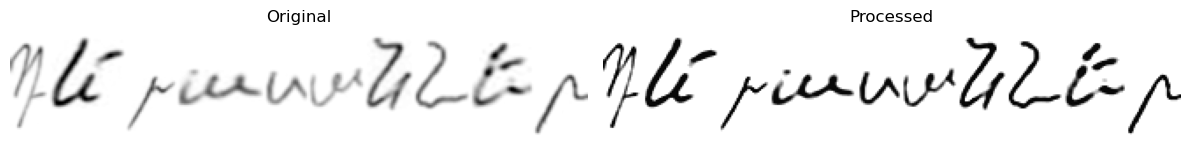

In [18]:
img_norm = img.astype(np.float32) / 255.0

temp_bgr = cv2.cvtColor((img_norm * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
enhanced_bgr = cv2.detailEnhance(temp_bgr, sigma_s=10, sigma_r=0.2)
enhanced = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0


def s_curve(x, gain=6):
    return 1 / (1 + np.exp(-gain * (x - 0.5)))


contrasted = s_curve(enhanced, gain=6)

# compressing overly dark strokes slightly for a more uniform results
compressed = contrasted.copy()
compressed[compressed < 0.2] = (
    0.25 * compressed[compressed < 0.2] + 0.15
)  # lift shadows slightly

img_8bit = (compressed * 255).astype(np.uint8)
blurred = cv2.GaussianBlur(img_8bit, (3, 3), 0.8)
sharpened = cv2.addWeighted(img_8bit, 1.15, blurred, -0.15, 0)

final = np.clip(sharpened, 0, 255).astype(np.uint8)
background_mask = final > 230  # pixels that are nearly white
final[background_mask] = 255


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Processed")
plt.imshow(final, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [15]:
def process_synthetic_image(img):
    """
    Enhances a synthetic grayscale image to make it appear more realistic.
    Applies detail enhancement, contrast adjustment via an s-curve,
    selective compression of dark regions, and sharpening.

    Parameters:
        img (numpy.ndarray): Input grayscale image (uint8 format).

    Returns:
        numpy.ndarray: Refined image with improved texture and contrast (uint8 format).
    """

    img_norm = img.astype(np.float32) / 255.0
    temp_bgr = cv2.cvtColor((img_norm * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    enhanced_bgr = cv2.detailEnhance(temp_bgr, sigma_s=10, sigma_r=0.2)
    enhanced = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    def s_curve(x, gain=6):
        """
        Applies an S-curve transformation to enhance contrast in an image.

        Parameters:
            x (numpy.ndarray): Normalized image array with values in [0, 1].
            gain (float): Controls the steepness of the curve. Higher gain increases contrast near mid-tones.

        Returns:
            numpy.ndarray: Transformed image with enhanced contrast.
        """
        return 1 / (1 + np.exp(-gain * (x - 0.5)))

    contrasted = s_curve(enhanced, gain=6)

    compressed = contrasted.copy()
    compressed[compressed < 0.2] = 0.25 * compressed[compressed < 0.2] + 0.15

    img_8bit = (compressed * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(img_8bit, (3, 3), 0.8)
    sharpened = cv2.addWeighted(img_8bit, 1.15, blurred, -0.15, 0)

    final = np.clip(sharpened, 0, 255).astype(np.uint8)
    background_mask = final > 230
    final[background_mask] = 255

    return final


def refine_images_in_folder(root_dir):
    """
    Applies inplace synthetic image refinement to all grayscale images in a directory tree.

    Parameters:
        root_dir (str): Path to the root directory containing images to be processed.

    Returns:
        None
    """

    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp")):
                path = os.path.join(dirpath, fname)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    processed = process_synthetic_image(img)
                    cv2.imwrite(path, processed)
                    print(f"Processed: {path}")
                else:
                    print(f"Failed to read image: {path}")

In [16]:
# os.chdir('..')
os.getcwd()

'c:\\Users\\anial\\Downloads'

In [ ]:
refine_images_in_folder(
    "./synthetic_words_inverted"
)  # just refine the inverted images inplace

# Data Augmentation for the Real Handwritten Images

The scripts below are designed to augment data in a way that mimic real-life handwritings. The main augmentation function with a given probability can

- Stretch or squeeze the image horizontally and/or vertically
- Add Gaussian noise
- Change the stroke thickness

In [10]:
def augment_data(img):
    """
    Applies random data augmentation techniques to a grayscale image until at least one transformation is performed.

    Augmentations include:
    - Stroke thickness adjustment (erosion or dilation)
    - Gaussian noise addition
    - Horizontal/vertical squeezing or stretching via affine transformation

    Parameters:
        img (numpy.ndarray): Grayscale input image with values in [0, 255].

    Returns:
        numpy.ndarray: Augmented image as uint8 with pixel values in [0, 255].
    """

    img = img.astype(np.float32)
    h, w = img.shape
    original = img.copy()
    augmented = False

    while not augmented:
        img = original.copy()
        augmented = False  # reset flag

        # stroke thickness
        rand = random.random()
        if rand < 0.33:
            # thinning stroke
            img = 255 - img
            img = cv2.erode(img, np.ones((2, 2), np.uint8), iterations=1)
            img = 255 - img
            augmented = True
        elif rand < 0.66:
            # thickening stroke
            img = 255 - img
            img = cv2.dilate(img, np.ones((2, 2), np.uint8), iterations=1)
            img = 255 - img
            augmented = True
        # else:
        # keeping stroke thickness

        # add noise
        if random.random() < 0.6:
            # adding gaussian noise
            noise_std = random.uniform(1, 3)
            noise = np.random.normal(0, noise_std, img.shape)
            img += noise
            img = np.clip(img, 0, 255)
            augmented = True

        # squeeze or stretch
        if random.random() < 0.7:
            # applying affine scale
            center = (w / 2, h / 2)

            scale_x = random.random() < 0.8
            scale_y = random.random() < 0.5

            fx = random.uniform(0.70, 1.20) if scale_x else 1.0
            fy = random.uniform(0.75, 1.25) if scale_y else 1.0

            if fx != 1.0 or fy != 1.0:
                # if fx < 1.0: print("squeezing horizontally")
                # if fx > 1.0: print("stretching horizontally")
                # if fy < 1.0: print("squeezing vertically")
                # if fy > 1.0: print("stretching vertically")

                T = np.array(
                    [[fx, 0, center[0] * (1 - fx)], [0, fy, center[1] * (1 - fy)]],
                    dtype=np.float32,
                )

                img = cv2.warpAffine(
                    img,
                    T,
                    (w, h),
                    flags=cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_CONSTANT,
                    borderValue=255,
                )
                augmented = True

    img[img > 245] = 255
    return img.astype(np.uint8)

In [23]:
def show_original_vs_augmented_together(original):
    """
    Displays the original and augmented versions of a grayscale image side-by-side using matplotlib.

    Parameters:
        original (numpy.ndarray): Input grayscale image with pixel values in [0, 255].

    Returns:
        numpy.ndarray: The augmented version of the input image.
    """

    augmented = augment_data(original)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Augmented")
    plt.imshow(augmented, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return augmented

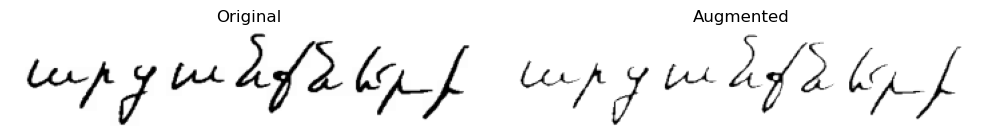

In [26]:
img_path = "./capstone-htr/data_preparation/real.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
aug_img = show_original_vs_augmented_together(img)  # again a basic demo

In [27]:
def show_original_vs_augmented(original, num_samples=5):
    """
    Displays multiple original vs augmented image comparisons.

    Args:
        original (np.ndarray): Original grayscale image.
        num_samples (int): Number of augmented variations to generate and display.
    """
    for i in range(num_samples):
        augmented = augment_data(original)

        plt.figure(figsize=(10, 5))
        plt.title("")
        plt.imshow(augmented, cmap="gray")
        plt.axis("off")
        plt.show()

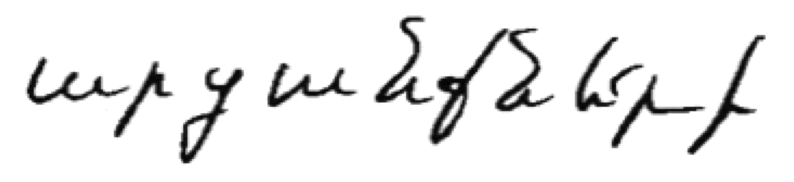

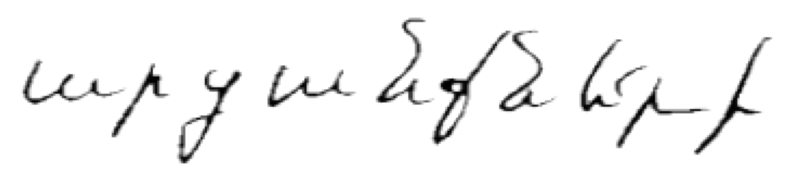

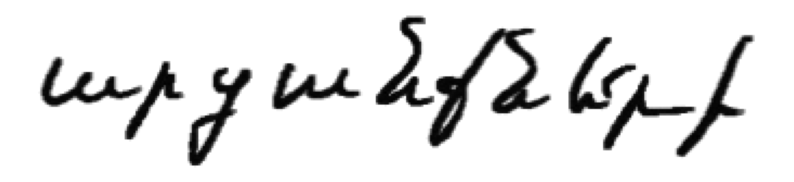

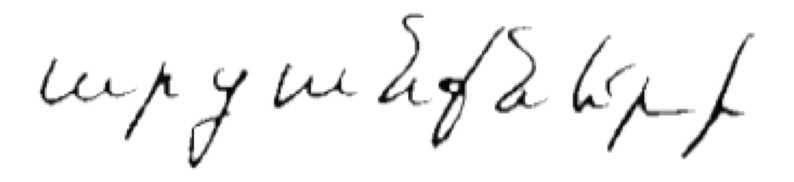

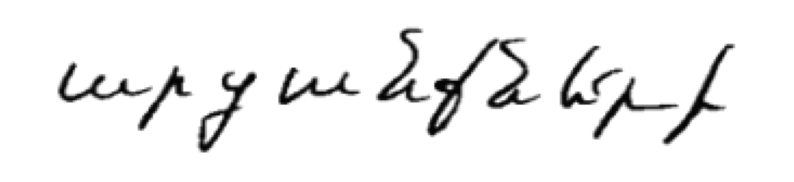

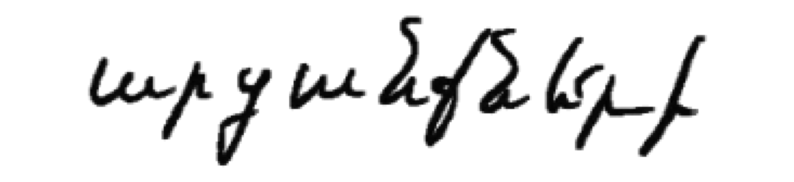

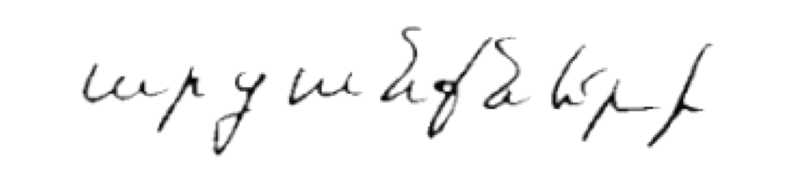

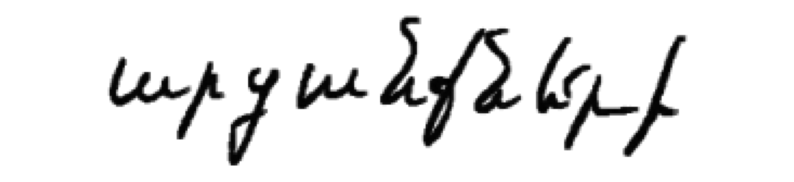

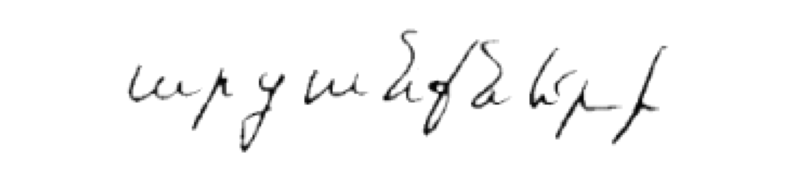

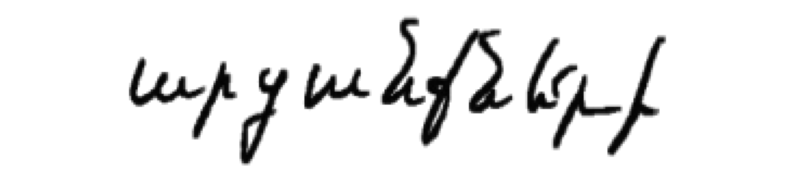

In [ ]:
show_original_vs_augmented(
    img, num_samples=10
)  # observe in how many ways a single image can be augmented!

The augmented images still keep their base name and get the extension `_annotated_#` , they can be easily added to the annotations file. The script below achieves that

In [9]:
def write_augmented_annotations(image_folder, annotation_path, output_annotation_path):
    """
    Generates augmented versions of word images and updates the annotation file accordingly.

    For each image in the annotation file, creates 1 to 3 augmented samples using `augment_data`,
    saves them in the same folder, and appends new rows to the annotation TSV file.

    Parameters:
        image_folder (str): Path to the folder containing the original word images.
        annotation_path (str): Path to the original annotation file (TSV format).
        output_annotation_path (str): Path where the updated annotation file should be saved.

    Returns:
        None
    """

    annots = pd.read_csv(annotation_path, sep="\t", names=["image", "label"])
    annots["image"] = annots["image"].apply(os.path.basename)

    new_rows = []

    for idx, row in annots.iterrows():
        original_name = row["image"]
        label = row["label"]
        image_path = os.path.join(image_folder, original_name)

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping unreadable image: {image_path}")
            continue

        n_aug = random.randint(
            1, 3
        )  # generate new augmented image for each word n times (1-3, randomly)
        name, ext = os.path.splitext(original_name)

        if ext == "":
            ext = ".png"

        for i in range(n_aug):
            aug_img = augment_data(img)
            aug_name = f"{name}_augmented_{i+1}{ext}"
            aug_path = os.path.join(image_folder, aug_name)
            cv2.imwrite(aug_path, aug_img)
            new_rows.append({"image": aug_name, "label": label})

    augmented_df = pd.concat([annots, pd.DataFrame(new_rows)], ignore_index=True)
    augmented_df.to_csv(output_annotation_path, sep="\t", index=False, header=False)

In [2]:
def convert_all_to_grayscale(image_folder):
    """
    Converts all images in a specified folder to grayscale in-place.

    Only processes files with image extensions (.png, .jpg, .jpeg, .bmp, .tif).
    If an image is already single-channel, it is left unchanged.

    Parameters:
        image_folder (str): Path to the folder containing images to convert.

    Returns:
        None
    """

    for fname in os.listdir(image_folder):
        if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif")):
            path = os.path.join(image_folder, fname)
            img = cv2.imread(path)
            if img is None:
                print(f"Skipping unreadable: {fname}")
                continue
            if img.ndim == 3:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(path, img_gray)

In [7]:
convert_all_to_grayscale(
    "./cropped_words"
)  # converted everything to grayscale for later passing to the model properly

The final annotations file were manually modified by me a lot throughout the process (mostly to get rid of my typos during label checking), the very first annotations file can be found in the `data_preparation` folder

you can use the below code to visually understand what happened with the file after adding the augmented files

In [ ]:
write_augmented_annotations(
    "./cropped_words",
    "./capstone-htr/data_preparation/annotations.txt",
    "./capstone-htr/data_preparation/annotations.txt",
)  # updated annotations in annotations file